In [1]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM

np.random.seed(0)

Using TensorFlow backend.


In [23]:
#load data
df = pd.read_csv('../Datasets/SST1_dataset/Processed_SST1.tsv', sep='\t')
train_df = pd.read_csv('/home/shikhar/Datasets/Kaggle_dataset/train.tsv', sep='\t', header=0)
test_df = pd.read_csv('/home/shikhar/Datasets/Kaggle_dataset/test.tsv', sep='\t', header=0)

raw_docs_train = train_df['Phrase'].values
# raw_docs_test = test_df['Phrase'].values
raw_docs_test = df[df.split_ind == 2]['Phrases'].values
sentiment_train = train_df['Sentiment'].values
sentiment_test = df[df.split_ind == 2]['Label'].values
num_labels = len(np.unique(sentiment_train))

#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_train.append(stemmed)

print ("pre-processing test docs...")
processed_docs_test = []
for doc in raw_docs_test:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_test.append(stemmed)

processed_docs_all = np.concatenate((processed_docs_train, processed_docs_test), axis=0)

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())
print ("dictionary size: ", dictionary_size )
#dictionary.save('dictionary.dict')
#corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

word_id_test, word_ids = [], []
for doc in processed_docs_test:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_test.append(word_ids)
    word_id_len.append(len(word_ids))

seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
word_id_test = sequence.pad_sequences(np.array(word_id_test), maxlen=seq_len)
y_train_enc = np_utils.to_categorical(sentiment_train, num_labels)
y_test_enc = np_utils.to_categorical(sentiment_test, num_labels)

#LSTM
print ("fitting LSTM ...")
model = Sequential()
model.add(Embedding(dictionary_size, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(word_id_train, y_train_enc, epochs=50,
          validation_data=(word_id_test, y_test_enc),
          batch_size=256, 
          verbose=1)

pre-processing train docs...
pre-processing test docs...
dictionary size:  13189
converting to token ids...
fitting LSTM ...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:65: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:66: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`


Train on 156060 samples, validate on 2210 samples
Epoch 1/50
156060/156060 [==============================] - 49s - loss: 0.9982 - acc: 0.5977 - val_loss: 1.3463 - val_acc: 0.4222
Epoch 2/50
156060/156060 [==============================] - 49s - loss: 0.8184 - acc: 0.6637 - val_loss: 1.3727 - val_acc: 0.4154
Epoch 3/50
156060/156060 [==============================] - 49s - loss: 0.7676 - acc: 0.6802 - val_loss: 1.3988 - val_acc: 0.4330
Epoch 4/50
156060/156060 [==============================] - 49s - loss: 0.7282 - acc: 0.6942 - val_loss: 1.4285 - val_acc: 0.4262
Epoch 5/50
156060/156060 [==============================] - 49s - loss: 0.6961 - acc: 0.7059 - val_loss: 1.4628 - val_acc: 0.4140
Epoch 6/50
156060/156060 [==============================] - 49s - loss: 0.6698 - acc: 0.7148 - val_loss: 1.4902 - val_acc: 0.4281
Epoch 7/50
156060/156060 [==============================] - 49s - loss: 0.6482 - acc: 0.7222 - val_loss: 1.5716 - val_acc: 0.4235
Epoch 8/50
156060/156060 [==============

KeyboardInterrupt: 

In [18]:
test_pred = model.predict_classes(word_id_test)

#make a submission
# df[]['Pred'] = test_pred.reshape(-1,1) 
# header = ['PhraseId', 'Sentiment']
# df.to_csv('./lstm_sentiment.csv', columns=header, index=False, header=True)

2208/2210 [============================>.] - ETA: 0s

In [5]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
res_df = pd.read_csv('./res1_google.txt', sep=',', header=0)
res_df

,acc,loss,val_acc,val_loss
0,1.2328,0.5125,1.6573,0.2045
1,1.2201,0.5138,1.6449,0.1864
2,1.2164,0.5152,1.6403,0.2195
3,1.2120,0.5160,1.6266,0.2308
4,1.2062,0.5180,1.6410,0.2226
5,1.1972,0.5209,1.6183,0.2457
6,1.1838,0.5262,1.6172,0.2457
7,1.1663,0.5357,1.5936,0.2525
8,1.1466,0.5455,1.5840,0.2891
9,1.1236,0.5560,1.5479,0.3036


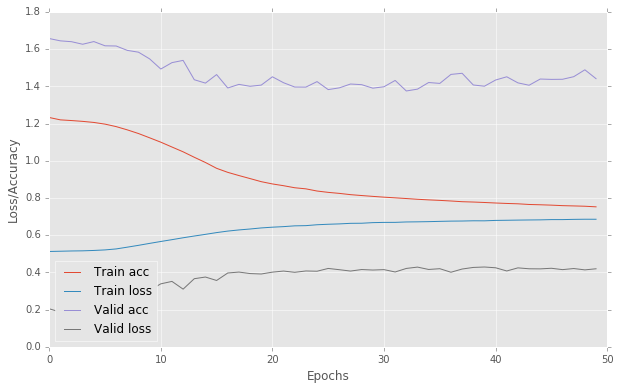

In [20]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(res_df['acc'])

plt.plot(res_df['loss'])

plt.plot(res_df['val_acc'])

plt.plot(res_df['val_loss'])

plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=3)


plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'

# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)

plt.show()